In [1]:
import glob
import os
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import h5py
import time
import random
import torch
import torch.multiprocessing
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, Dataset, DataLoader, ConcatDataset
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision.models import resnet34
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report 
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from collections import OrderedDict
mps_device = torch.device("mps")

In [2]:
csv_files = glob.glob('Data'+'/**/*.csv', recursive=True)

features = []
    
for file in csv_files:
    data = pd.read_csv(file, header=None, na_values="?", skiprows=5)
    data.columns = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"] 
    data = data.drop(columns = ["time"])    
    features.append(data)

X_train = []
X_test = []
for i,f in enumerate(features):
    if len(f) != 480:
        print(np.shape(f))
        for i in range(480-len(f)):
            f = pd.concat([f, f.mean().to_frame().T])
        print(np.shape(f))
    if 'dataset1.csv' in csv_files[i] or 'dataset2.csv' in csv_files[i] or 'dataset3.csv' in csv_files[i]:
        if 'dataset3' in csv_files[i] and 'bending' in csv_files[i]:
            X_train.append(f.values)
        else:
            X_test.append(f.values)
    else:
        X_train.append(f.values)

(479, 6)
(480, 6)


In [3]:
Y_train = []
Y_test = []
for i,a in enumerate(csv_files):
    if 'dataset1.csv' in a or 'dataset2.csv' in a or 'dataset3.csv' in a:
        if 'dataset3' in a and 'bending' in a:
            Y_train.append(a.split('/')[1])
        else:
            Y_test.append(a.split('/')[1])
    else:
        Y_train.append(a.split('/')[1])

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
label_binarizer = LabelBinarizer().fit(Y_train)
Y_onehot_test = label_binarizer.transform(Y_test)
Y_onehot_train = label_binarizer.transform(Y_train)

In [4]:
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=6, hidden_size=128, num_layers=1, nonlinearity='tanh')
        self.fc = nn.Linear(480*128, 7)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out.view([480*128])
        out = self.fc(out)
        return out

model = RNN().to(mps_device)

loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-04, weight_decay=1e-5)

In [5]:
train_losses, train_accs = [], []

model.eval()
for epoch in range(1):  
    train_acc = 0
    train_loss = 0
    for i in range(len(X_train)):
        
        input = torch.tensor(X_train[i], dtype=torch.float32).to(mps_device)
        y = torch.tensor(Y_onehot_train[i], dtype=torch.float32).to(mps_device)
        y_class = np.argmax(Y_onehot_train[i])
        
    
        # Forward Pass
        output = model(input)
        y_pred = torch.argmax(output).to('cpu')
    
        # Loss 
        loss = loss_func(output, y)
    
        # Backprop
        opt.zero_grad()
        loss.backward()
        
        # Optimize
        opt.step()

            
        train_loss += loss_func(output, y).item()/len(X_train)
        train_acc += 100 * (y_pred == y_class)/len(X_train)
        
    train_losses.append(train_loss)
    train_accs.append(train_acc)

model.train()

RNN(
  (rnn): RNN(6, 128)
  (fc): Linear(in_features=61440, out_features=7, bias=True)
)

In [6]:
model.train()
for epoch in range(20):  
    train_acc = 0
    train_loss = 0
    for i in range(len(X_train)):
        
        input = torch.tensor(X_train[i], dtype=torch.float32).to(mps_device)
        y = torch.tensor(Y_onehot_train[i], dtype=torch.float32).to(mps_device)
        y_class = np.argmax(Y_onehot_train[i])
        
    
        # Forward Pass
        output = model(input)
        y_pred = torch.argmax(output).to('cpu')
    
        # Loss 
        loss = loss_func(output, y)
    
        # Backprop
        opt.zero_grad()
        loss.backward()
        
        # Optimize
        opt.step()

            
        train_loss += loss_func(output, y).item()/len(X_train)
        train_acc += 100 * (y_pred == y_class)/len(X_train)
        
    train_losses.append(train_loss)
    train_accs.append(train_acc)

model.eval()

RNN(
  (rnn): RNN(6, 128)
  (fc): Linear(in_features=61440, out_features=7, bias=True)
)

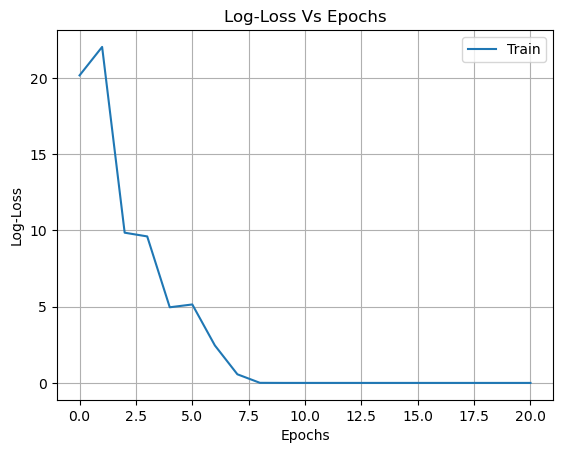

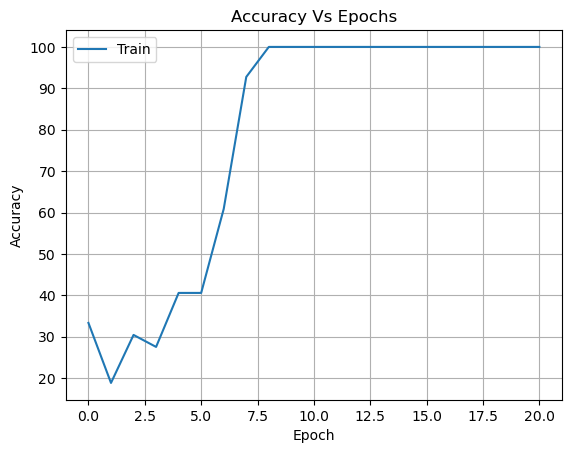

In [7]:
plt.figure()
plt.plot(train_losses, label='Train')
plt.xlabel('Epochs')
plt.ylabel('Log-Loss')
plt.title('Log-Loss Vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_accs, label='Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Accuracy : 73.68%


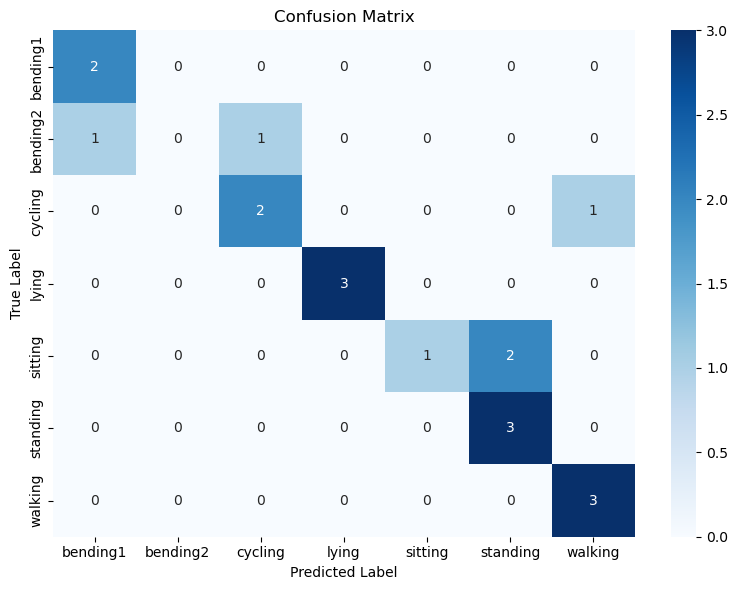

In [8]:
test_acc = 0
y_preds = []
y_original = []
model.eval()
for i in range(len(X_test)):
    input = torch.tensor(X_test[i], dtype=torch.float32).to(mps_device)
    y = torch.tensor(Y_onehot_test[i], dtype=torch.float32).to(mps_device)
    y_class = np.argmax(Y_onehot_test[i])
    y_original.append(y_class)

    # Forward Pass
    output = model(input)
    y_pred = torch.argmax(output).to('cpu')
    y_preds.append(y_pred)

    test_acc += 100 * (y_pred == y_class)/len(X_test)
    
print(f'Test Accuracy : {test_acc:.4}%')
cm = confusion_matrix(y_original, y_preds)
plt.figure(figsize=(8, 6))
class_names = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [9]:
X_train_new = []
for x in X_train:
    X_train_new.append(np.concatenate((x[:240][:], x[240:][:]), axis=1))

X_test_new = []
for x in X_test:
    X_test_new.append(np.concatenate((x[:240][:], x[240:][:]), axis=1))

In [10]:
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=12, hidden_size=128, num_layers=1, nonlinearity='relu')
        self.fc = nn.Linear(240*128, 7)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out.view([240*128])
        out = self.fc(out)
        return out

model = RNN().to(mps_device)

loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-04, weight_decay=1e-5)

In [11]:
train_losses, train_accs = [], []

model.eval()
for epoch in range(1):  
    train_acc = 0
    train_loss = 0
    for i in range(len(X_train_new)):
        
        input = torch.tensor(X_train_new[i], dtype=torch.float32).to(mps_device)
        y = torch.tensor(Y_onehot_train[i], dtype=torch.float32).to(mps_device)
        y_class = np.argmax(Y_onehot_train[i])
        
    
        # Forward Pass
        output = model(input)
        y_pred = torch.argmax(output).to('cpu')
    
        # Loss 
        loss = loss_func(output, y)
    
        # Backprop
        opt.zero_grad()
        loss.backward()
        
        # Optimize
        opt.step()

            
        train_loss += loss_func(output, y).item()/len(X_train)
        train_acc += 100 * (y_pred == y_class)/len(X_train)
        
    train_losses.append(train_loss)
    train_accs.append(train_acc)

model.train()

RNN(
  (rnn): RNN(12, 128)
  (fc): Linear(in_features=30720, out_features=7, bias=True)
)

In [12]:
model.train()
for epoch in range(20):  
    train_acc = 0
    train_loss = 0
    for i in range(len(X_train_new)):
        
        input = torch.tensor(X_train_new[i], dtype=torch.float32).to(mps_device)
        y = torch.tensor(Y_onehot_train[i], dtype=torch.float32).to(mps_device)
        y_class = np.argmax(Y_onehot_train[i])
        
    
        # Forward Pass
        output = model(input)
        y_pred = torch.argmax(output).to('cpu')
    
        # Loss 
        loss = loss_func(output, y)
    
        # Backprop
        opt.zero_grad()
        loss.backward()
        
        # Optimize
        opt.step()

            
        train_loss += loss_func(output, y).item()/len(X_train)
        train_acc += 100 * (y_pred == y_class)/len(X_train)
        
    train_losses.append(train_loss)
    train_accs.append(train_acc)

model.eval()

RNN(
  (rnn): RNN(12, 128)
  (fc): Linear(in_features=30720, out_features=7, bias=True)
)

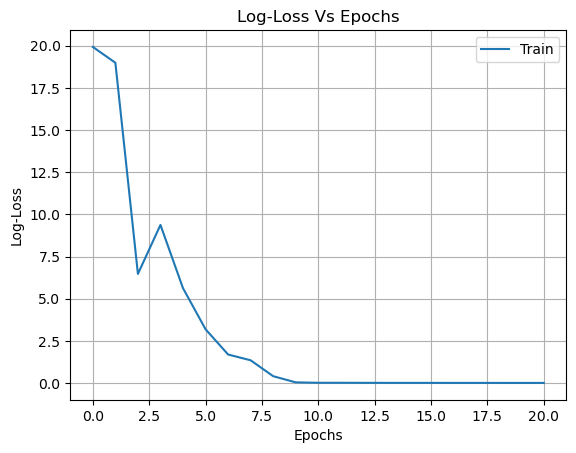

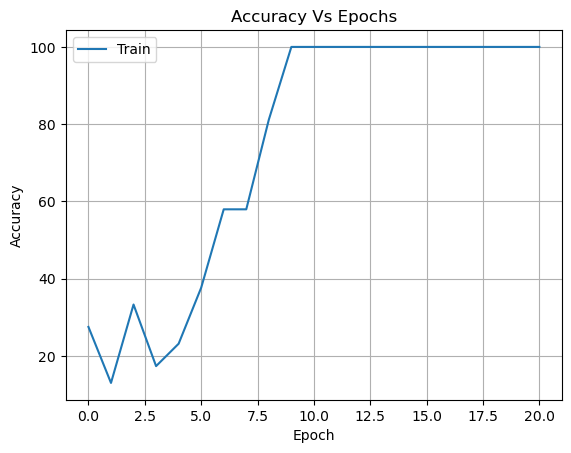

In [13]:
plt.figure()
plt.plot(train_losses, label='Train')
plt.xlabel('Epochs')
plt.ylabel('Log-Loss')
plt.title('Log-Loss Vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_accs, label='Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Accuracy : 78.95%


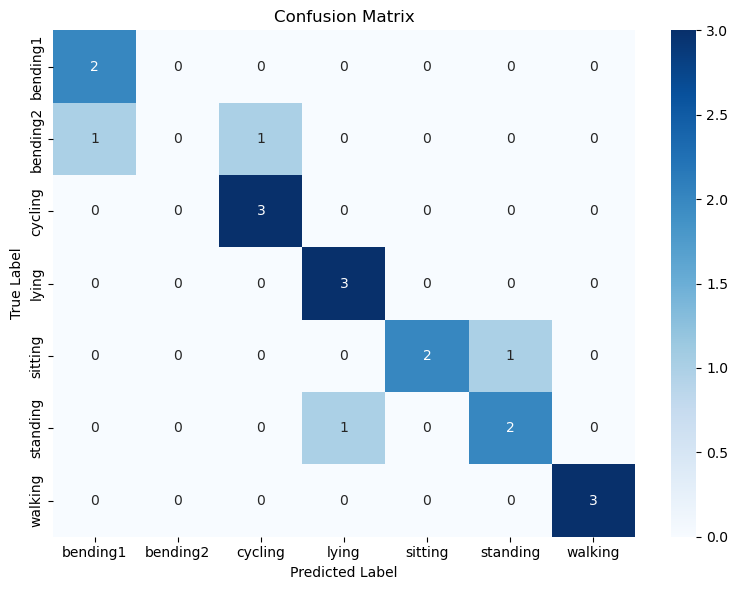

In [14]:
test_acc = 0
y_preds = []
y_original = []
model.eval()
for i in range(len(X_test_new)):
    input = torch.tensor(X_test_new[i], dtype=torch.float32).to(mps_device)
    y = torch.tensor(Y_onehot_test[i], dtype=torch.float32).to(mps_device)
    y_class = np.argmax(Y_onehot_test[i])
    y_original.append(y_class)

    # Forward Pass
    output = model(input)
    y_pred = torch.argmax(output).to('cpu')
    y_preds.append(y_pred)

    test_acc += 100 * (y_pred == y_class)/len(X_test_new)
    
print(f'Test Accuracy : {test_acc:.4}%')
cm = confusion_matrix(y_original, y_preds)
plt.figure(figsize=(8, 6))
class_names = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [15]:
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=6, hidden_size=128, num_layers=1, nonlinearity='relu')
        self.fc = nn.Linear(480*128, 7)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out.view([480*128])
        out = self.fc(out)
        return out

model = RNN().to(mps_device)

loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-04, weight_decay=1e-5)

In [16]:
train_losses, train_accs = [], []

model.eval()
for epoch in range(1):  
    train_acc = 0
    train_loss = 0
    for i in range(len(X_train)):
        
        input = torch.tensor(X_train[i], dtype=torch.float32).to(mps_device)
        y = torch.tensor(Y_onehot_train[i], dtype=torch.float32).to(mps_device)
        y_class = np.argmax(Y_onehot_train[i])
        
    
        # Forward Pass
        output = model(input)
        y_pred = torch.argmax(output).to('cpu')
    
        # Loss 
        loss = loss_func(output, y)
    
        # Backprop
        opt.zero_grad()
        loss.backward()
        
        # Optimize
        opt.step()

            
        train_loss += loss_func(output, y).item()/len(X_train)
        train_acc += 100 * (y_pred == y_class)/len(X_train)
        
    train_losses.append(train_loss)
    train_accs.append(train_acc)

model.train()

RNN(
  (rnn): RNN(6, 128)
  (fc): Linear(in_features=61440, out_features=7, bias=True)
)

In [17]:
model.train()
for epoch in range(20):  
    train_acc = 0
    train_loss = 0
    for i in range(len(X_train)):
        
        input = torch.tensor(X_train[i], dtype=torch.float32).to(mps_device)
        y = torch.tensor(Y_onehot_train[i], dtype=torch.float32).to(mps_device)
        y_class = np.argmax(Y_onehot_train[i])
        
    
        # Forward Pass
        output = model(input)
        y_pred = torch.argmax(output).to('cpu')
    
        # Loss 
        loss = loss_func(output, y)
    
        # Backprop
        opt.zero_grad()
        loss.backward()
        
        # Optimize
        opt.step()

            
        train_loss += loss_func(output, y).item()/len(X_train)
        train_acc += 100 * (y_pred == y_class)/len(X_train)
        
    train_losses.append(train_loss)
    train_accs.append(train_acc)

model.eval()

RNN(
  (rnn): RNN(6, 128)
  (fc): Linear(in_features=61440, out_features=7, bias=True)
)

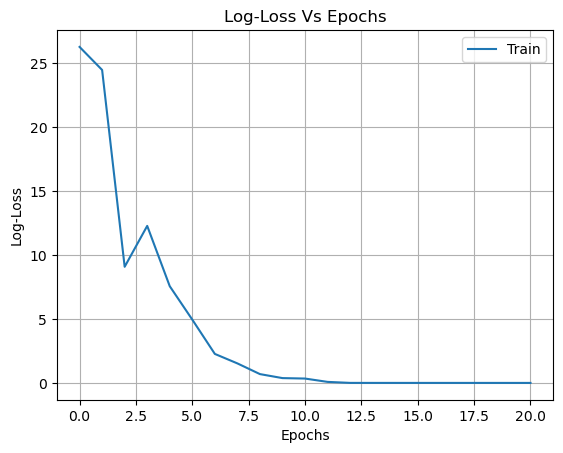

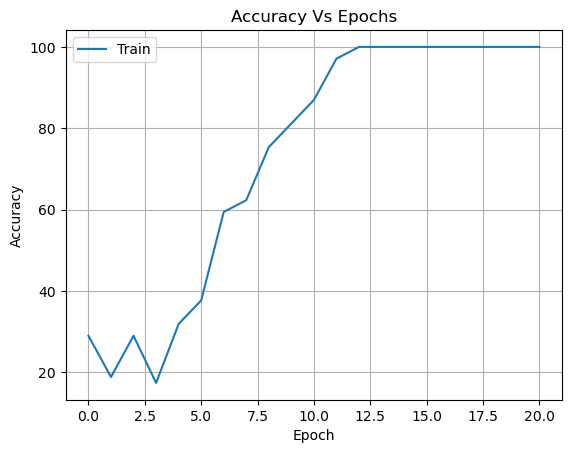

In [18]:
plt.figure()
plt.plot(train_losses, label='Train')
plt.xlabel('Epochs')
plt.ylabel('Log-Loss')
plt.title('Log-Loss Vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_accs, label='Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Accuracy : 73.68%


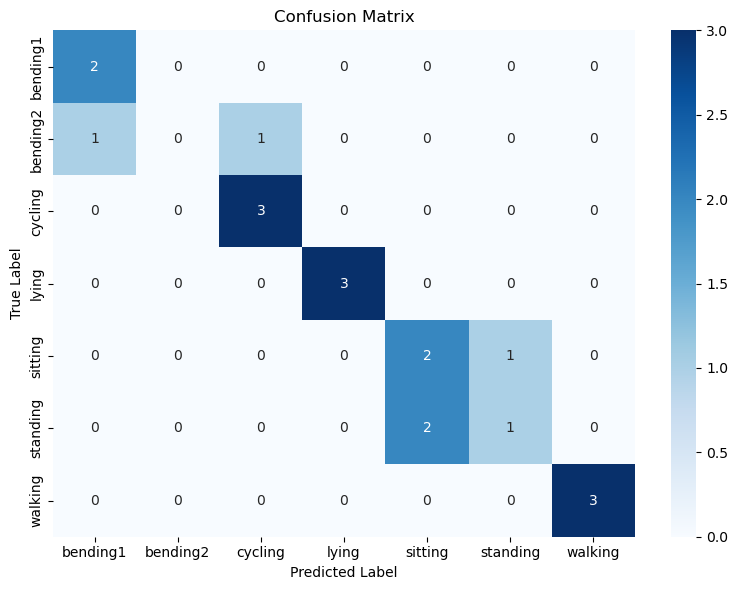

In [19]:
test_acc = 0
y_preds = []
y_original = []
model.eval()
for i in range(len(X_test)):
    input = torch.tensor(X_test[i], dtype=torch.float32).to(mps_device)
    y = torch.tensor(Y_onehot_test[i], dtype=torch.float32).to(mps_device)
    y_class = np.argmax(Y_onehot_test[i])
    y_original.append(y_class)

    # Forward Pass
    output = model(input)
    y_pred = torch.argmax(output).to('cpu')
    y_preds.append(y_pred)

    test_acc += 100 * (y_pred == y_class)/len(X_test)
    
print(f'Test Accuracy : {test_acc:.4}%')
cm = confusion_matrix(y_original, y_preds)
plt.figure(figsize=(8, 6))
class_names = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [20]:
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=6, hidden_size=128, num_layers=5, nonlinearity='tanh')
        self.fc = nn.Linear(480*128, 7)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out.view([480*128])
        out = self.fc(out)
        return out

model = RNN().to(mps_device)

loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-04, weight_decay=1e-5)

In [21]:
train_losses, train_accs = [], []

model.eval()
for epoch in range(1):  
    train_acc = 0
    train_loss = 0
    for i in range(len(X_train)):
        
        input = torch.tensor(X_train[i], dtype=torch.float32).to(mps_device)
        y = torch.tensor(Y_onehot_train[i], dtype=torch.float32).to(mps_device)
        y_class = np.argmax(Y_onehot_train[i])
        
    
        # Forward Pass
        output = model(input)
        y_pred = torch.argmax(output).to('cpu')
    
        # Loss 
        loss = loss_func(output, y)
    
        # Backprop
        opt.zero_grad()
        loss.backward()
        
        # Optimize
        opt.step()

            
        train_loss += loss_func(output, y).item()/len(X_train)
        train_acc += 100 * (y_pred == y_class)/len(X_train)
        
    train_losses.append(train_loss)
    train_accs.append(train_acc)

model.train()

RNN(
  (rnn): RNN(6, 128, num_layers=5)
  (fc): Linear(in_features=61440, out_features=7, bias=True)
)

In [22]:
model.train()
for epoch in range(20):  
    train_acc = 0
    train_loss = 0
    for i in range(len(X_train)):
        
        input = torch.tensor(X_train[i], dtype=torch.float32).to(mps_device)
        y = torch.tensor(Y_onehot_train[i], dtype=torch.float32).to(mps_device)
        y_class = np.argmax(Y_onehot_train[i])
        
    
        # Forward Pass
        output = model(input)
        y_pred = torch.argmax(output).to('cpu')
    
        # Loss 
        loss = loss_func(output, y)
    
        # Backprop
        opt.zero_grad()
        loss.backward()
        
        # Optimize
        opt.step()

            
        train_loss += loss_func(output, y).item()/len(X_train)
        train_acc += 100 * (y_pred == y_class)/len(X_train)
        
    train_losses.append(train_loss)
    train_accs.append(train_acc)

model.eval()

RNN(
  (rnn): RNN(6, 128, num_layers=5)
  (fc): Linear(in_features=61440, out_features=7, bias=True)
)

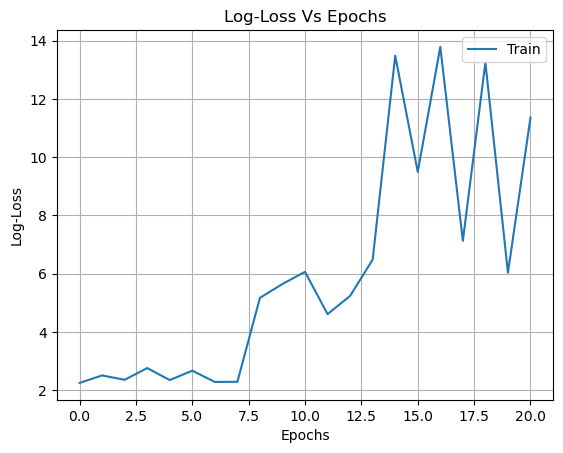

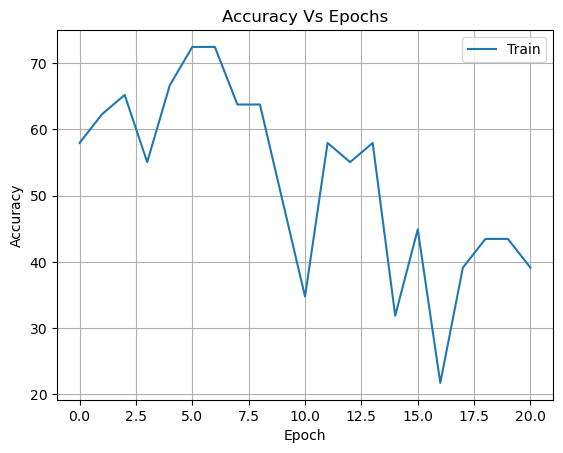

In [23]:
plt.figure()
plt.plot(train_losses, label='Train')
plt.xlabel('Epochs')
plt.ylabel('Log-Loss')
plt.title('Log-Loss Vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_accs, label='Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Accuracy : 31.58%


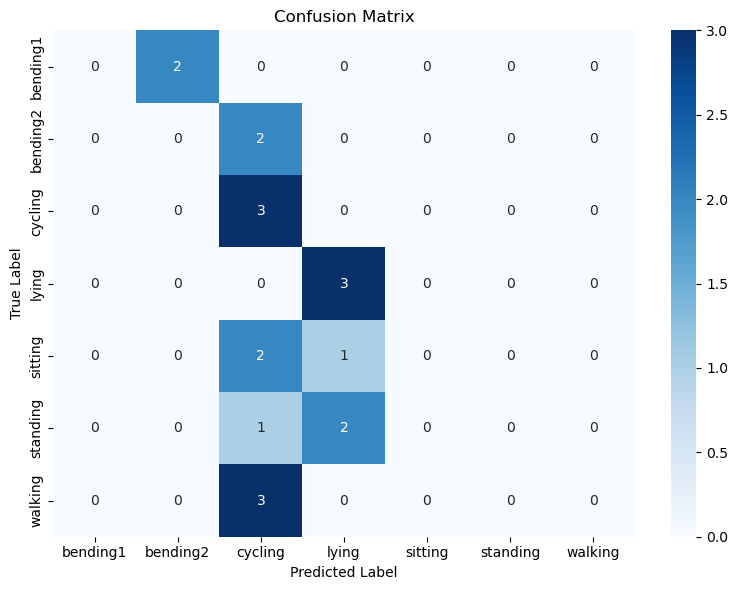

In [24]:
test_acc = 0
y_preds = []
y_original = []
model.eval()
for i in range(len(X_test)):
    input = torch.tensor(X_test[i], dtype=torch.float32).to(mps_device)
    y = torch.tensor(Y_onehot_test[i], dtype=torch.float32).to(mps_device)
    y_class = np.argmax(Y_onehot_test[i])
    y_original.append(y_class)

    # Forward Pass
    output = model(input)
    y_pred = torch.argmax(output).to('cpu')
    y_preds.append(y_pred)

    test_acc += 100 * (y_pred == y_class)/len(X_test)
    
print(f'Test Accuracy : {test_acc:.4}%')
cm = confusion_matrix(y_original, y_preds)
plt.figure(figsize=(8, 6))
class_names = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()